<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Line-intersection" data-toc-modified-id="Line-intersection-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Line intersection</a></span></li><li><span><a href="#Benchmark---putting-stuff-on-the-GPU" data-toc-modified-id="Benchmark---putting-stuff-on-the-GPU-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Benchmark - putting stuff on the GPU</a></span></li><li><span><a href="#Raycaster---Parallelizing-segments-and-poses" data-toc-modified-id="Raycaster---Parallelizing-segments-and-poses-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Raycaster - Parallelizing segments and poses</a></span><ul class="toc-item"><li><span><a href="#Examples" data-toc-modified-id="Examples-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Examples</a></span></li></ul></li></ul></div>

# CUDA 2D Raycaster for Line Maps

In [1]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:500px; }</style>"));

HTML{String}("<style>.rendered_html.text_cell_render {max-width:500px; }</style>")

In [2]:
#nbx --fname="src/cuda_raycaster_line_map_b.jl"
push!(LOAD_PATH, "src");
using MyUtils
using CUDA
using BenchmarkTools
using Colors, Plots
col = palette(:default);
import Base: @doc

In [3]:
#nbx
"""
    griddims = cuda_grid(datadims::Tuple{Vararg{Int}}, 
                         blockdims::Tuple{Vararg{Int}})

Given data dimensions `datadims` and number of threads 
in each dimension `blockdims` returns the respective 
grid dimensions `griddims` such that

    griddims[i] = ceil(Int, datadims[i]/blockdims[i])

"""
function cuda_grid(datadims::Tuple{Vararg{Int}}, blockdims::Tuple{Vararg{Int}})
    griddims = ceil.(Int, datadims./blockdims)
    return griddims
end

cuda_grid

## Line intersection

Compute the intersection of two lines by solving: $x + s \cdot dx = y + t \cdot dy$.

Implementation from my `Geometry.jl` package:

```julia
function line_intersect(x, x′, y, y′)
    dx = x′ - x
    dy = y′ - y
    v  = x - y
    if det([-dx dy]) == 0
        return [Inf;Inf]
    end
    s, t = inv([-dx dy])*v
    return s,t
end;
```

And here's a version without arrays that we can use within a cuda kernel later.

In [4]:
#nbx
function line_intersection(x1, x2, x1′, x2′, y1, y2, y1′, y2′)
    dx1, dx2 = x1′ - x1, x2′ - x2
    dy1, dy2 = y1′ - y1, y2′ - y2
    
    v1 = (x1 - y1)
    v2 = (x2 - y2)
    
    a, b = -dx1, dy1
    c, d = -dx2, dy2
    
    det = a*d - c*b
    
    if det == 0
        return Inf,Inf
    end
    
    s = 1/det*(  d*v1 - b*v2)
    t = 1/det*(- c*v1 + a*v2)

    return s,t
end;

## Benchmark - putting stuff on the GPU

Just check if moving between CPU and GPU becomes a bottleneck.

In [7]:
@btime      CuArray($(ones(100,100,100))) samples=3 evals=3;
@btime      CuArray{Float64}(undef, 100,100,100) samples=3 evals=3;
@btime Inf.*CuArray{Float64}(undef, 100,100,100) samples=4 evals=4;
@btime Inf *CuArray{Float64}(undef, 100,100,100) samples=4 evals=4;
@btime Inf.*CUDA.ones(100,100,100) samples=4 evals=4;
@btime Inf *CUDA.ones(100,100,100) samples=4 evals=4;

  824.838 μs (4 allocations: 176 bytes)
  3.683 μs (4 allocations: 176 bytes)
  16.122 μs (33 allocations: 2.09 KiB)
  16.227 μs (33 allocations: 2.09 KiB)
  21.938 μs (35 allocations: 2.12 KiB)
  21.393 μs (35 allocations: 2.12 KiB)


```julia
CuArray   824.838 μs (4 allocations: 176 bytes)
            4.030 μs (4 allocations: 176 bytes)
           86.347 μs (33 allocations: 2.09 KiB)
           16.236 μs (33 allocations: 2.09 KiB)
           25.285 μs (35 allocations: 2.12 KiB)
CUDA.ones  22.581 μs (35 allocations: 2.12 KiB)
```

In [6]:
function bench_cuarray(x,y,z)
    x_  = CuArray(x)
    y_  = CuArray(y)
    z_  = CuArray(z)
end

n = 1_000
m = 1_000
x = rand(n,2)
y = rand(m,4)
z = rand(n,4)

bs = []
for e=1:6
    n = 10^e
    x = rand(n,2)
    y = rand(n,2);
    z = rand(n,2);
    b = @benchmark bench_cuarray($x,$y,$z) samples=3 evals=3;
    push!(bs, b)
end

mean.(bs)

6-element Vector{BenchmarkTools.TrialEstimate}:
 30.593 μs
 29.697 μs
 41.361 μs
 121.738 μs
 722.841 μs
 5.416 ms

```julia
10   >> 33.175 μs
10^2 >> 32.889 μs
10^3 >> 36.669 μs
10^4 >> 134.479 μs
10^5 >> 753.159 μs
10^6 >> 6.102 ms
```

## Raycaster - Parallelizing segments and poses

In [5]:
#nbx

function cast_kernel!(Z, X, P, fov=2π)

    ix = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    iy = (blockIdx().y - 1) * blockDim().y + threadIdx().y
    sx = gridDim().x * blockDim().x
    sy = gridDim().y * blockDim().y
            
    num_a = size(Z,2)
    r     = fov/(num_a-1)
    
    for i = ix:sx:size(X,1), j = iy:sy:size(P,1)
        
        # convert everything into pose coords
        x1 , x2  = X[i,1] - P[j,1], X[i,2] - P[j,2]
        x1′, x2′ = X[i,3] - P[j,1], X[i,4] - P[j,2]
        dx1, dx2 = x1′-x1, x2′-x2
        y1 , y2  = 0, 0
        a1 = atan(x2 , x1 ) - P[j,3]
        a2 = atan(x2′, x1′) - P[j,3]
        a1 = mod(a1 + π, 2π) - π
        a2 = mod(a2 + π, 2π) - π

        # Ensure a1 < a2
        if a1 > a2
            a1, a2 = a2, a1
        end
        

        # Check if we cross from `-π+a` to `π-b`
        if a2 - a1 > π
            # Get the start end end bin
            zero = - fov/2;
            k1 = Int(floor((-π + r/2 - zero)/r))+1
            k2 = Int(floor((a1 + r/2 - zero)/r))+1
            
            k1′ = Int(floor((a2 + r/2 - zero)/r))+1
            k2′ = Int(floor((π + r/2 - zero)/r))+1
            
            ks = ((k1,k2),(k1′,k2′))
        else
            # Get the start end end bin
            zero = - fov/2;
            k1 = Int(floor((a1 + r/2 - zero)/r))+1
            k2 = Int(floor((a2 + r/2 - zero)/r))+1
            
            ks = ((k1,k2),)
            
        end
        
        
        for (k1,k2) in ks, k = k1:k2
            if !(1 <= k <= num_a)
               continue 
            end

            a = zero + (k-1)*r + P[j,3] 
            y1′, y2′ = cos(a), sin(a)

            s, t = line_intersection(x1, x2, x1′, x2′, y1, y2, y1′, y2′)
            if 0 < t && 0 <= s <= 1    
                @inbounds CUDA.@atomic Z[j,k] = min(Z[j,k], t)
            end


        end
    end
    return
end

function cast_cu!(Z, X, P; fov=2π, blockdims=(16,16))
    n = size(X,1)
    m = size(P,1)
    
    griddims = cuda_grid((n,m), blockdims)
    CUDA.@sync begin
        @cuda threads=blockdims blocks=griddims cast_kernel!(Z, X, P, fov)
    end
end

cast_cu! (generic function with 1 method)

In [6]:
n = 500
m = 500
x = 5*(2*rand(n,4).-1.0)
p = zeros(m, 3)
z = ones(m, 360)
    
println("`cast!` GPU -vs- CPU")
println("x: $(size(x)), p: $(size(p))")

x_ = CuArray(x)
z_ = CuArray(z)
p_ = CuArray(p)

n = size(x_,1)
m = size(p_,1)
datadims  = (n,m)
blockdims = (16,16)
griddims  = cuda_grid(datadims, blockdims)
println("data: $(datadims), block: $(blockdims), grid: $(griddims)")
@cuda threads=blockdims blocks=griddims cast_kernel!(z_,x_,p_)
@btime cast_cu!($z_,$x_,$p_; blockdims=(16,16)) samples=1 evals=1;

`cast!` GPU -vs- CPU
x: (500, 4), p: (500, 3)
data: (500, 500), block: (16, 16), grid: (32, 32)
  2.198 ms (73 allocations: 4.27 KiB)


```julia
`cast!` GPU -vs- CPU
x: (500, 4), p: (500, 3)
data: (500, 500), block: (16, 16), grid: (32, 32)
>>  2.163 ms (74 allocations: 4.56 KiB)


`cast!` GPU -vs- CPU
x: (1000, 4), p: (1, 3)
data: (1000, 1), block: (16, 16), grid: (63, 1)
>>  266.594 μs (25 allocations: 1.33 KiB)
```

### Examples

In [7]:
using Geometry
using GridSlam
Base.Vector(p::Pose) = [p.x;p.hd]
include("src/unpack_data.jl");

Loading `data/data_3.jld2` ...

	_segs 	Vector{Segment}
	_xs 	Vector{Vector{Float64}}
	_hds 	Vector{Float64}
	_ps 	Vector{Pose}
	_dxs 	Vector{Vector{Float64}}
	_dhds 	Vector{Float64}
	_us 	Vector{Tuple{Vector{Float64}, Float64}}
	_as 	Vector{Float64}
	_zs 	Vector{Any}
	_ss 	Vector{Vector{Measurement}}
	_fov 	Float64
	_zmax 	Int64
	_T 	Int64

To take a look call `glimpse_at_data(_segs, _ps, _ss)`


In [14]:
fov = 2π
_as = [range(-fov/2, fov/2, 361)...]

p_    = CuArray(stack(Vector.(_ps[1:10])))
segs_ = CuArray(stack(Vector.(_segs)))
z_    = CuArray(Inf*ones(size(p_,1), length(_as)));

n = size(segs_,1)
m = size(p_,1)

datadims  = (n,m) 
blockdims = (16,16)
griddims  = cuda_grid(datadims, blockdims)

println("Data dim: |env| = $(size(_segs)), |a| = $(size(_as))")
println("Threads per Block: $(prod(blockdims))")
println("Block dim: $(blockdims)")
println("Grid  dim: $(griddims)")
println()

@cuda threads=blockdims blocks=griddims cast!(z_,segs_,p_,fov)

Data dim: |env| = (427,), |a| = (361,)
Threads per Block: 256
Block dim: (16, 16)
Grid  dim: (27, 1)



CUDA.HostKernel{typeof(cast!), Tuple{CuDeviceMatrix{Float64, 1}, CuDeviceMatrix{Float64, 1}, CuDeviceMatrix{Float64, 1}, Float64}}(cast!, CuFunction(Ptr{CUDA.CUfunc_st} @0x000000000f8fbad0, CuModule(Ptr{CUDA.CUmod_st} @0x000000000f8f1140, CuContext(0x00000000058b05c0, instance 2362f134fbbc0085))), CUDA.KernelState(Ptr{Nothing} @0x00007f15abe00000))

In [15]:
size(z_)

(10, 361)

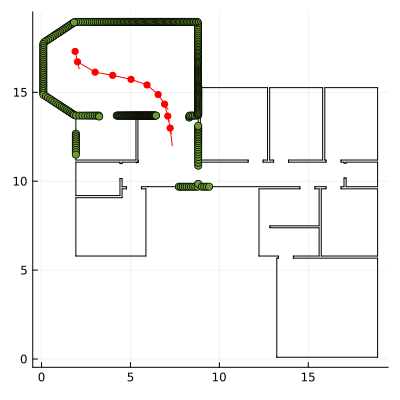

In [16]:
z = Array(z_)

t = 6
ys = stack([_ps[t].x] .+ polar_inv(z[t,:], _as .+ _ps[t].hd))
# # ---------------------------------------
myplot = plot(size=(400,400), aspect_ratio=:equal, legend=nothing)
plot!(_segs, c=:black)
scatter!.(_ps[1:10])
scatter!(ys[:,1], ys[:,2])
myplot